## Predicting credit card defaults from UCI ML credit card clients data set

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
from scipy import stats
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
df = pd.read_excel(file, sheet_name='Data',skiprows=range(1))
df.rename(columns={'default payment next month':'default'}, inplace=True)

Let's read the file, create a dataframe and change the label of target variable column to a shorter one.

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 1. Exploratory Data Analysis

First, let's look what's the proportion of defaulting customers in our data set.

In [4]:
d = min(df['default'].value_counts())
print('The number of defaulting customers in database:', d)
print('% of defaulting customers:', d/30000*100)

The number of defaulting customers in database: 6636
% of defaulting customers: 22.12


More than one in five customers will default the card payment next month. That's pretty high... <br>
OK, let's check for the distribution of the data variables and outliers

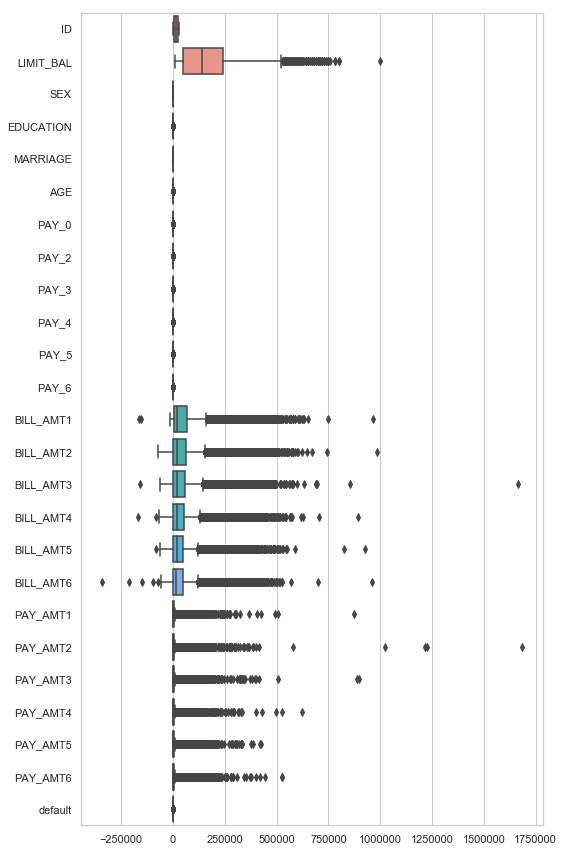

In [5]:
sns.set(style="whitegrid")
g = sns.boxplot(data = df, orient = 'h')
g.figure.set_size_inches(8,12)
plt.tight_layout()
plt.show()

There are quite a few outliers, let's remove rows with data point z-score>3 and assign to a new dataframe

In [6]:
z = np.abs(stats.zscore(df))
df_o = df[(z < 3).all(axis=1)]

Check the data dimensions now

In [7]:
df_o.shape

(26429, 25)

Plot the histograms once again

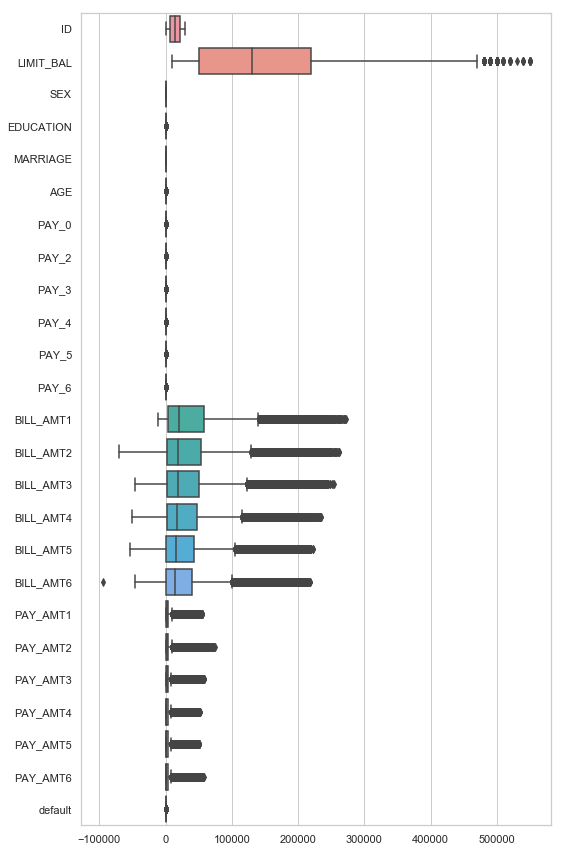

In [8]:
sns.set(style="whitegrid")
g = sns.boxplot(data = df_o, orient = 'h')
g.figure.set_size_inches(8,12)
plt.tight_layout()
plt.show()

In [9]:
# no NaNs
# df_o.isnull().sum()

Now lets check the correlation between independent variables

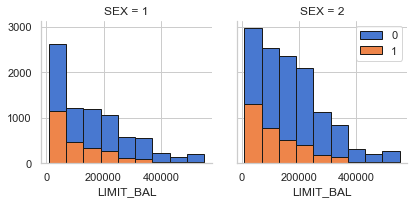

In [10]:
bins = np.linspace(df_o.LIMIT_BAL.min(), df_o.LIMIT_BAL.max(), 10)
g = sns.FacetGrid(df_o, col="SEX", hue="default", palette="muted", col_wrap=2)
g.map(plt.hist, 'LIMIT_BAL', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

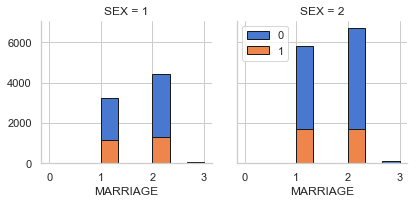

In [11]:
bins = np.linspace(df_o.MARRIAGE.min(), df_o.MARRIAGE.max(), 10)
g = sns.FacetGrid(df_o, col="SEX", hue="default", palette="muted", col_wrap=2)
g.map(plt.hist, 'MARRIAGE', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

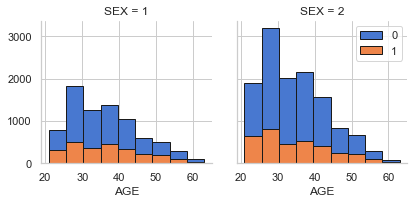

In [12]:
bins = np.linspace(df_o.AGE.min(), df_o.AGE.max(), 10)
g = sns.FacetGrid(df_o, col="SEX", hue="default", palette="muted", col_wrap=2)
g.map(plt.hist, 'AGE', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

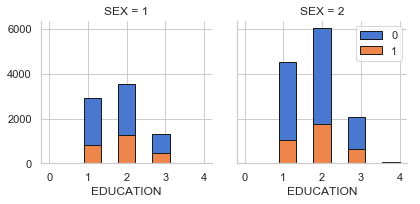

In [13]:
bins = np.linspace(df_o.EDUCATION.min(), df_o.EDUCATION.max(), 10)
g = sns.FacetGrid(df_o, col="SEX", hue="default", palette="muted", col_wrap=2)
g.map(plt.hist, 'EDUCATION', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

In [14]:
df_o.groupby(['SEX'])['default'].value_counts(normalize=True)

SEX  default
1    0          0.755025
     1          0.244975
2    0          0.788469
     1          0.211531
Name: default, dtype: float64

In [15]:
df_o['EDUCATION'].value_counts()

2    12575
1     9278
3     4452
4      110
0       14
Name: EDUCATION, dtype: int64

In [16]:
df_o.groupby(['EDUCATION'])['default'].value_counts(normalize=True)

EDUCATION  default
0          0          1.000000
1          0          0.801574
           1          0.198426
2          0          0.763101
           1          0.236899
3          0          0.751123
           1          0.248877
4          0          0.936364
           1          0.063636
Name: default, dtype: float64

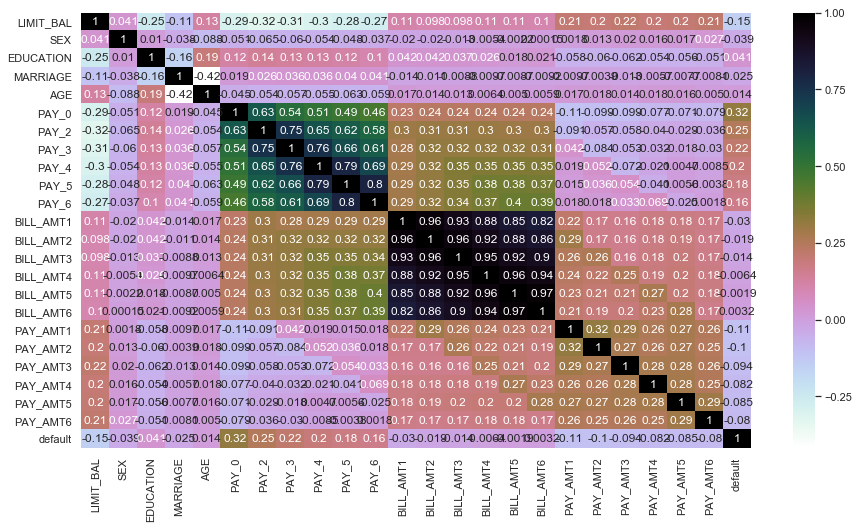

In [17]:
df_o = df_o.drop(['ID'],1)
cd_cor = df_o.corr()

plt.figure(figsize=(15,8))
colormap = plt.cm.cubehelix_r
ax = sns.heatmap(cd_cor, annot = True, cmap=colormap)

## 2. Feature Engineering

We can see that variables "BILL_AMT(1-6)" have high correlation, so let's join them into one variable that has their mean value. 

In [18]:
col = df_o.loc[: , "BILL_AMT1":"BILL_AMT6"]
df_o['bill_mean'] = col.mean(axis=1)

Variables "PAY_(0-6)" also have high correlation. Their values represent number of monhts the payments have been delayed with '-1' indicating payment on time. Therefor we are interested only in maximal value of these 6 variables. 

In [19]:
col2 = df_o.loc[: , 'PAY_0':'PAY_6']
df_o['pay_delay'] = col2.max(axis=1)

Now let's drop columns that wont be used in the model from cd_df1 dataframe.

In [20]:
df_o = df_o.drop(['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1', 'BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6' ],1)

In [21]:
df_o.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default',
       'bill_mean', 'pay_delay'],
      dtype='object')

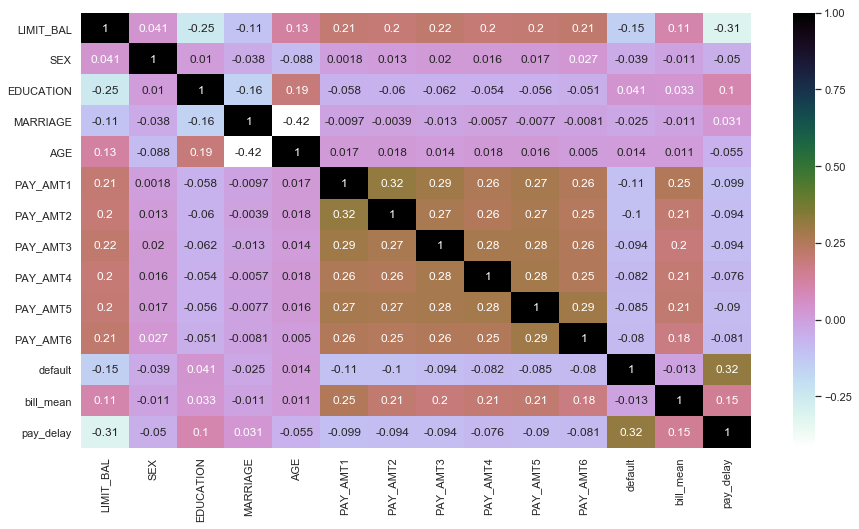

In [22]:
cd_cor = df_o.corr()

plt.figure(figsize=(15,8))
colormap = plt.cm.cubehelix_r
ax = sns.heatmap(cd_cor, annot = True, cmap=colormap)

I'll use `df_hot` dataframe for further model training and apply One Hot Encoding to `education` and `pay_delay` variables.

In [23]:
df_hot = pd.concat([df_o,pd.get_dummies(df_o['EDUCATION'])], axis=1)

In [24]:
df_hot = df_hot.drop(df_hot.columns[[2, 14]], axis=1)

In [25]:
df_hot = df_hot.rename(columns={df_hot.columns[13]:'ED1',
                                df_hot.columns[14]:'ED2',
                                df_hot.columns[15]:'ED3',
                                df_hot.columns[16]:'ED4'}
                      )

In [26]:
df_hot['pay_delay'].value_counts()

 0    12579
 2     6732
-1     2845
-2     1926
 1     1579
 3      768
Name: pay_delay, dtype: int64

In [27]:
df_hot = pd.concat([df_hot,pd.get_dummies(df_hot['pay_delay'])], axis=1)

In [28]:
df_hot = df_hot.drop(df_hot.columns[[12]], axis=1)

In [29]:
df_hot = df_hot.rename(columns={df_hot.columns[16]:'PAY_DL1',
                                df_hot.columns[17]:'PAY_DL2',
                                df_hot.columns[18]:'PAY_DL3',
                                df_hot.columns[19]:'PAY_DL4',
                                df_hot.columns[20]:'PAY_DL5',
                                df_hot.columns[21]:'PAY_DL6'}
                      )

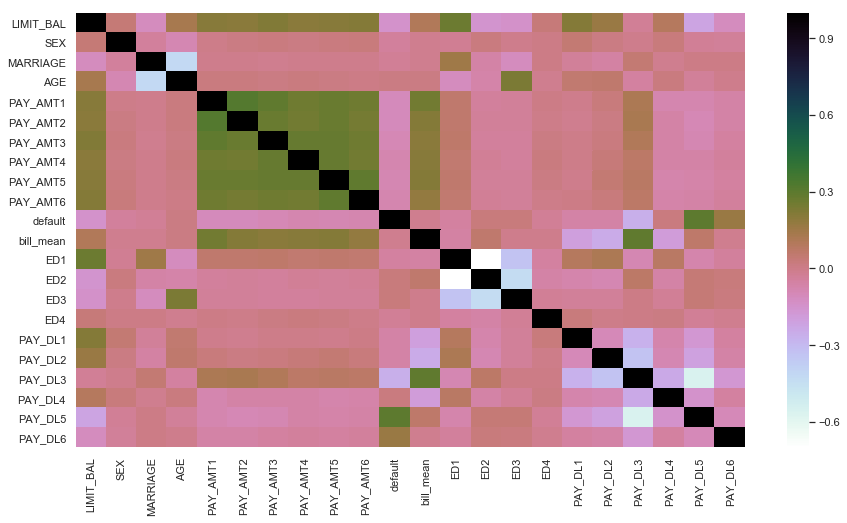

In [30]:
cd_cor = df_hot.corr()

plt.figure(figsize=(15,8))
colormap = plt.cm.cubehelix_r
ax = sns.heatmap(cd_cor, cmap=colormap)

## Fitting models

For this classification problem I'm going to apply the following algorithms:<br>
* Naive Bayes
* Logistic Regression
* Random Forest
* SVC
* K-Nearest Neighbours

To minimise overfitting I will run cross-validation and use AUC as the initial selection criteria as well as variation of results accross different samples.

Let's create arrays for train and test sets...

In [33]:
X1 = np.asarray(df_hot.drop(['default'], axis=1))
y1 = np.asarray(df_hot[['default']])

In [34]:
df_hot.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,...,ED1,ED2,ED3,ED4,PAY_DL1,PAY_DL2,PAY_DL3,PAY_DL4,PAY_DL5,PAY_DL6
0,20000,2,1,24,0,689,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,120000,2,2,26,0,1000,1000,1000,0,2000,...,0,1,0,0,0,0,0,0,1,0
2,90000,2,2,34,1518,1500,1000,1000,1000,5000,...,0,1,0,0,0,0,1,0,0,0
3,50000,2,1,37,2000,2019,1200,1100,1069,1000,...,0,1,0,0,0,0,1,0,0,0
4,50000,1,1,57,2000,36681,10000,9000,689,679,...,0,1,0,0,0,0,1,0,0,0


...and normalise the data before fiting it to logistic regression model.

In [35]:
from sklearn.model_selection import cross_val_score
X1 = preprocessing.StandardScaler().fit(X1).transform(X1)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X1, y1, test_size=0.1, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (23786, 21) (23786, 1)
Test set: (2643, 21) (2643, 1)


In [37]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
scores1_GNB = cross_val_score(GNB, X1, y1.ravel(), cv=3, scoring = "roc_auc")
#scores2_GNB = cross_val_score(GNB, X2, y2.ravel(), cv=10, scoring = "f1")

In [38]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01,class_weight='balanced', solver='saga',max_iter=100)
scores1_LR = cross_val_score(LR, X1, y1.ravel(), cv=3, scoring = "roc_auc")
#scores2_LR = cross_val_score(LR, X2, y2.ravel(), cv=10, scoring = "f1")

In [39]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100, random_state=0)
scores1_RF = cross_val_score(RF, X1, y1.ravel(), cv=3, scoring = "roc_auc")
#scores2_RF = cross_val_score(RF, X2, y2.ravel(), cv=8, scoring = "f1")

In [40]:
from sklearn.svm import SVC 
VM = SVC(C = 0.01, kernel = 'rbf', gamma = 'scale', class_weight = 'balanced')
scores1_SVC = cross_val_score(VM, X1, y1.ravel(), cv=3, scoring = "roc_auc")
#scores2_SVC = cross_val_score(VM, X2, y2.ravel(), cv=8, scoring = "f1")

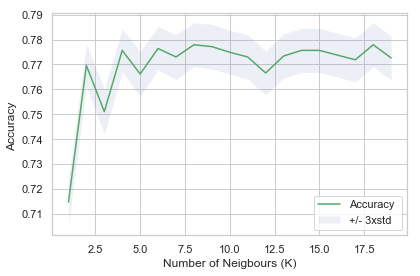

The best accuracy was with 0.777903897086644 with k= 8


In [41]:
# calculate the best  k for KNN classifier.

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train.ravel())
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test.ravel(), yhat)
   
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

# plot accuracy graph
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neigbours (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [42]:
NGH = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1)
scores1_KNN = cross_val_score(NGH, X1, y1.ravel(), cv=3, scoring = "roc_auc")

In [43]:
result_df = pd.DataFrame(columns=['roc_auc, hot','Variance, hot'],
                         index=['Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVC', 'KNN'])

In [44]:
result_df.iloc[0] = pd.Series({'roc_auc, hot':scores1_GNB.mean(), 'Variance, hot':np.std(scores1_GNB)})
result_df.iloc[1] = pd.Series({'roc_auc, hot':scores1_LR.mean(), 'Variance, hot':np.std(scores1_LR)})
result_df.iloc[2] = pd.Series({'roc_auc, hot':scores1_RF.mean(), 'Variance, hot':np.std(scores1_RF)})
result_df.iloc[3] = pd.Series({'roc_auc, hot':scores1_SVC.mean(), 'Variance, hot':np.std(scores1_SVC)})
result_df.iloc[4] = pd.Series({'roc_auc, hot':scores1_KNN.mean(), 'Variance, hot':np.std(scores1_KNN)})

In [45]:
result_df = result_df.sort_values('roc_auc, hot', ascending = False,  axis=0)
result_df.head(6)

,"roc_auc, hot","Variance, hot"
Logistic Regression,0.748526,0.0135622
Random Forest,0.746512,0.0126859
SVC,0.733992,0.00915762
Naive Bayes,0.712806,0.0131437
KNN,0.704987,0.00862251


The first three classifiers achieve very similare scores. Let's run GridSearchCV on their params to determine the best result on the test set.

### LR parameter grid search

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model_gs = LogisticRegression(class_weight='balanced', multi_class = 'auto', max_iter=1000)

param_grid = {'C':[0.01, 1, 5], 'solver': ['newton-cg', 'liblinear', 'lbfgs', 'sag', 'saga']}
grid = GridSearchCV(model_gs, param_grid, scoring = 'roc_auc', cv=3)
best_model = grid.fit(X_train,y_train.ravel())


In [55]:
print("Best parameters set:")
best_parameters=grid.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    print(grid.best_score_)

Best parameters set:
	C: 5
0.7494093455552827
	solver: 'saga'
0.7494093455552827


In [58]:
from sklearn.metrics import roc_auc_score
model = LogisticRegression(C=5, class_weight='balanced', solver='saga', multi_class = 'auto', max_iter=1000)
best_model1 = model.fit(X_train,y_train.ravel())
y_pred1 = best_model1.predict(X_test)
print('AUC score', roc_auc_score(y_test, y_pred1))

AUC score 0.7072151033431171


### SVC parameter grid search
To save computation time I will run grid search step by step: 1. kernel, 2. C parameter, 3. gamma value.

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
VM = SVC(class_weight = 'balanced')

param_grid = {'C':[0.01], 'kernel': ['poly', 'sigmoid', 'rbf'], 'gamma' : ['scale']}
grid = GridSearchCV(VM, param_grid, scoring = 'roc_auc', cv=3)
best_model = grid.fit(X_train,y_train.ravel())

In [60]:
print("Best parameters set:")
best_parameters=grid.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    print(grid.best_score_)

Best parameters set:
	C: 0.01
0.7347885684051553
	gamma: 'scale'
0.7347885684051553
	kernel: 'rbf'
0.7347885684051553


In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
VM = SVC(class_weight = 'balanced')

param_grid = {'C':[0.01, 0.1, 1, 10], 'kernel': ['rbf'], 'gamma' : ['scale']}
grid = GridSearchCV(VM, param_grid, scoring = 'roc_auc', cv=3)
best_model = grid.fit(X_train,y_train.ravel())

In [62]:
print("Best parameters set:")
best_parameters=grid.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    print(grid.best_score_)

Best parameters set:
	C: 0.1
0.7403144792758666
	gamma: 'scale'
0.7403144792758666
	kernel: 'rbf'
0.7403144792758666


In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
VM = SVC(class_weight = 'balanced')

param_grid = {'C':[0.1], 'kernel': ['rbf'], 'gamma' : [0.01, 0.1, 1, 10, 'scale']}
grid = GridSearchCV(VM, param_grid, scoring = 'roc_auc', cv=3)
best_model = grid.fit(X_train,y_train.ravel())

In [64]:
print("Best parameters set:")
best_parameters=grid.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    print(grid.best_score_)

Best parameters set:
	C: 0.1
0.7433042365086248
	gamma: 0.01
0.7433042365086248
	kernel: 'rbf'
0.7433042365086248


In [66]:
from sklearn.metrics import roc_auc_score

VM = SVC(C = 0.1, kernel = 'rbf', class_weight = 'balanced', gamma = 0.01)

best_model2 = VM.fit(X_train,y_train.ravel())
y_pred2 = best_model2.predict(X_test)
print('AUC score', roc_auc_score(y_test, y_pred2))

AUC score 0.6988216379266005


#### Conclusion: Logistic Regression delivers the highest AUC score.

Confusion matrix, without normalization
[[ 389  197]
 [ 513 1544]]


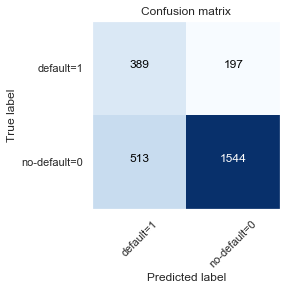

In [81]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

sns.set(style="dark")
cnf_matrix = confusion_matrix(y_test, y_pred1, labels=[1,0])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['default=1','no-default=0'],normalize= False,  title='Confusion matrix')

### Searching for optimal precision - recall threshold

Optimal threshold level: 0.70


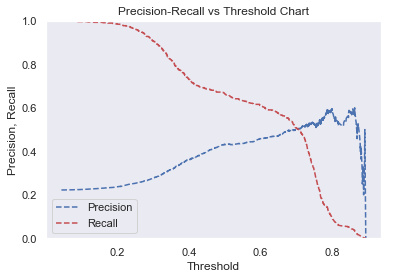

In [121]:
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve

y_probs = best_model1.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_probs[:,1]) 

#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

k = range(len(thresholds))
b = 0
gap=1
for x in k:
    b = abs(recall[x+1] - precision[x+1])
    if gap>b and thresholds[x]<0.8:
        gap = b
        threshold = thresholds[x+1]
print("Optimal threshold level: %.2f" % threshold)

In [122]:
df_prob = pd.DataFrame(y_probs, columns = {'prob0', 'prob1'})
df_prob.loc[df_prob['prob1'] >threshold, 'class_prob'] = 1
df_prob.loc[df_prob['prob1'] <=threshold, 'class_prob'] = 0

In [123]:
from sklearn.metrics import classification_report
y_treshold = df_prob['class_prob']
print (classification_report(y_test, y_treshold))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2057
           1       0.50      0.50      0.50       586

    accuracy                           0.78      2643
   macro avg       0.68      0.68      0.68      2643
weighted avg       0.78      0.78      0.78      2643



Lets plot the confusion matrix.

Confusion matrix, without normalization
[[ 295  291]
 [ 290 1767]]


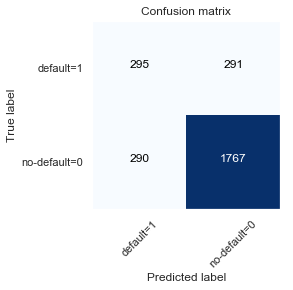

In [124]:
sns.set(style="dark")
cnf_matrix = confusion_matrix(y_test, y_treshold, labels=[1,0])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['default=1','no-default=0'],normalize= False,  title='Confusion matrix')

#### RESULTS: We have achieved 50% recal rate which is **27% increase over sample average** and 50% precision rate. <br> Weighted F1-score is 0.78 which confirms good accuracy of this classiefier model.